# Flatiron Phase 3 Project

## Aaron Galbraith

### Submitted: ———

# Business Understanding

A number of organizations install and manage water wells throughout the country of Tanzania. Some of these wells become unfunctional from time to time and need to be repaired or replaced.

The government of Tanzania funds over 9,000 of these wells, about 15%. The government would like to be able to predict which wells are going to remain functioning without having to systematically check each one.


# Data Understanding

## Import files

Here we'll import everything we need.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from itertools import combinations

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree

SEED = 10

First we'll open the various docs and see how big they are.

In [ ]:
df = pd.read_csv('../data/training_set_values.csv')
# show row and column counts
df.shape

In [ ]:
# show first few records
df.head()

"training_set_values" has 59,400 records.

In [ ]:
df = pd.read_csv('../data/training_set_labels.csv')
# show row and column counts
df.shape

In [ ]:
# show first few records
df.head()

In [ ]:
# show value counts for the target variable
df.status_group.value_counts()

"training_set_labels" just tells you what the status of those 59,400 records is.

In [ ]:
df = pd.read_csv('../data/test_set_values.csv')
# show row and column counts
df.shape

In [ ]:
# show first few records
df.head()

"test_set_values" is just like training_set_values, with fewer records (14,850).

In [ ]:
df = pd.read_csv('../data/SubmissionFormat.csv')
# show row and column counts
df.shape

In [ ]:
# show first few records
df.head()

"SubmissionFormat" is like training_set_labels except the contestant/data scientist has to provide the labels.

## Summary of available files

There is a training set consisting of 59,400 records, a set of labels for those 59,400 records,  a test set consisting of 14,850 records, and a template for submitting labels for those 14,850 test records to an online contest.

Because we do not have labels for the 14,850 records in the test set, those are useless to us. We will have to carve out training and test sets from the 59,400 records with known labels.

## Create the desired data set

As we drop records from the data set, we'll need to make sure we drop the *same* records from the target labels, so it will be necessary to join those two dataframes together first.

In [2]:
# load the data from two files
dfX = pd.read_csv('../data/training_set_values.csv')
dfy = pd.read_csv('../data/training_set_labels.csv')
# concatenate the files
df = pd.concat([dfX, dfy['status_group']], axis = 1)
# show rows and columns
df.shape

(59400, 41)

As we'll only be working with records of wells funded by the government, we should drop all other records before going any further. Once we've done that, we can drop the funder feature.

In [3]:
# drop all records of wells funded by any organization other than the government of Tanzania
df.drop(df[df['funder'] != 'Government Of Tanzania'].index, inplace=True, axis=0)
# drop this feature, as its values are all now uniform
df.drop(columns='funder', inplace=True)
# show rows and columns
df.shape

(9084, 40)

# Data preparation

### Duplicates

First we'll address duplicates.

In [4]:
# check for duplicates, excluding the ids
df[df.duplicated(subset=df.columns.difference(['id']))].shape

(8, 40)

There appear to be 8 duplicated records. We'll drop them.

In [5]:
# drop the duplicate records
df.drop(df[df.duplicated(subset=df.columns.difference(['id']))].index, inplace=True)
# show row and column counts
df.shape

(9076, 40)

## Missing values
Now we'll look at which columns have missing values.

In [18]:
# show columns with missing values and the number of values missing
df[df.columns[df.isna().any()]].isna().sum()

public_meeting    418
permit             41
dtype: int64

For any feature with missing values, our options are:

1. drop the feature
2. save the feature by imputing the missing values
3. save the feature by dropping the records with missing values

These are all categorical features, which means there is little hope for imputing their values. The only way we could hope to impute values for any of these features is if it made sense to assign the value of "other" to the missing values. Even then, this will only be worthwhile if doing so leaves us with sufficiently *few* unique values for that feature. The reason for this is that in a categorization project such as this one, it simply won't be useful to have a large number of unique values for any single feature.

If, say, 1-4 values comprised something like 70% of the records, then it *might* make sense to put all the rest — including the missing values — into an "other" value pile. But if the value counts are more or less evenly distributed, then there won't be much hope of imputing, and we'll have to decide whether to drop the feature or drop the records with missing values for that feature.

In [7]:
# show how many unique values each feature has, for the features that also have missing values
df[df.columns[df.isna().any()]].nunique()

installer             123
subvillage           3954
public_meeting          2
scheme_management      10
scheme_name           808
permit                  2
dtype: int64

Let's start with the worst offender, scheme name, which has the most missing values.

We can get a quick idea for its value counts by comparing the 25 unique values with the highest value counts.

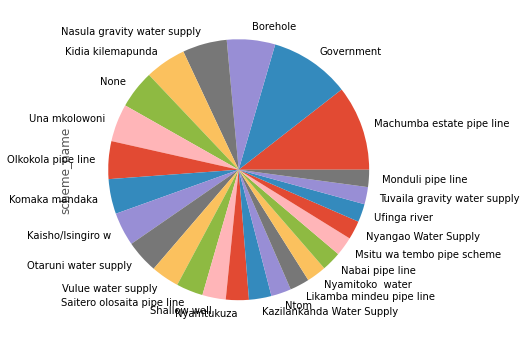

In [8]:
# plot pie chart of 25 unique values for scheme_name with highest value counts
df.scheme_name.value_counts().head(25).plot.pie(subplots=True, figsize = (11,6), legend=False);

These value counts are indeed quite widely distributed. One of the highest value counts, however, belongs to Government (meaning, according to the documentation, that the government is responsible for running the well), which may be important to our analysis of government-funded wells. We'll one-hot encode this feature to indicate which wells are run by the goverment.

In [9]:
# one-hot encode the scheme_name feature
df['scheme_name'] = df['scheme_name'].apply(lambda x: 1 if x == 'Government' else 0)
# reassign the type of the funder feature
df['scheme_name'] = df['scheme_name'].astype('int64')

Let's do the same analysis for the subvillage feature since it also has a great number of unique values.

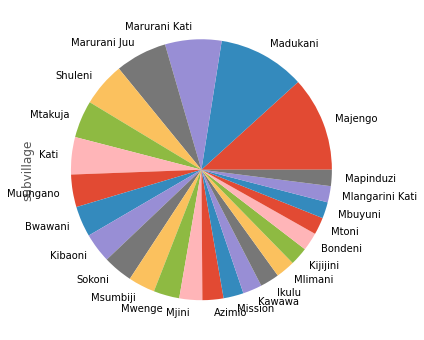

In [10]:
# plot pie chart of 25 unique values for subvillage with highest value counts
df.subvillage.value_counts().head(25).plot.pie(subplots=True, figsize = (11,6), legend=False);

These value counts are distributed too evenly and do not appear to be of any possible use. We'll drop the feature.

In [11]:
df.drop(columns='subvillage', inplace=True)
# show row and column counts
df.shape

(9076, 39)

Let's look at scheme management.

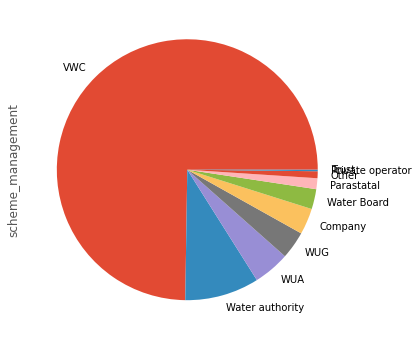

In [12]:
# plot pie chart of the unique values for scheme_management with highest value counts
df.scheme_management.value_counts().plot.pie(subplots=True, figsize = (11,6), legend=False);

Here we see an opportunity to group some values together. Let's replace any value with lower counts than "Other" as "Other".

In [13]:
other_vals = []

for val in df.scheme_management.value_counts().index:
    if len(df[df.scheme_management == val]) < len(df[df.scheme_management == 'Other']):
        other_vals.append(val)

df['scheme_management'] = df['scheme_management'].apply(lambda x: 'Other' if x in other_vals else x)
df['scheme_management'].fillna('Other', inplace=True)

Let's look at the installer feature.

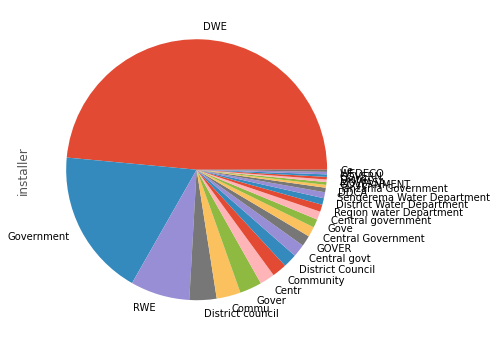

In [14]:
# plot pie chart of 25 unique values for installer with highest value counts
df.installer.value_counts().head(25).plot.pie(subplots=True, figsize = (11,6), legend=False);

Here again we can group anything with a value count smaller than that of RWE as "other".

In [15]:
other_vals = []

for val in df.installer.value_counts().index:
    if len(df[df.installer == val]) < len(df[df.installer == 'RWE']):
        other_vals.append(val)

df['installer'] = df['installer'].apply(lambda x: 'Other' if x in other_vals else x)
df['installer'].fillna('Other', inplace=True)

The remaining features with missing values — public_meeting and permit — have only two unique values each. It could get a little trickier to impute anything here. Let's look at those values, starting with public_meeting.

In [16]:
df.public_meeting.value_counts()

True     7823
False     835
Name: public_meeting, dtype: int64

In [17]:
df.permit.value_counts()

True     6767
False    2268
Name: permit, dtype: int64

It's difficult to justify imputing anything here, even an "other" category, so for each we'll have to either drop the feature or drop the records. The missing values for public_meeting are nearly 5% of the data, and we don't even know how helpful this feature will be yet, so it's safe to drop it.

In [19]:
df.drop(columns='public_meeting', inplace=True)
# show row and column counts
df.shape

(9076, 38)

There are fewer missing values for the permit feature, however, only about half of a percent, so we can instead drop those records. (And if we later discover that the permit feature doesn't help in our modeling, we can perhaps add those records back and drop the permit feature.)

# RESUME HERE, DROP PERMIT NAS AND ONE-HOT PERMIT AS IT'S BINARY

## Administrative features
The id, date_recorded, and recorded_by features won't help with any of our analysis. We can safely drop them.

In [ ]:
df.drop(columns=['id', 'date_recorded', 'recorded_by'], inplace=True)
# show row and column counts
df.shape

## Numerical features with potentially false zeros
We've tackled all the missing values already, but sometimes values of zero are entered when the value is actually missing.

Let's explore the numerical features and find how many zero values each has and what percentage of its values are zero.

In [ ]:
for col in df.select_dtypes(include=['number']).columns:
    count = df[col][abs(df[col]) == 0].count()
    pct = round(100*count/(len(df)),2)
    print(col, (19-len(col))*' ', count, (5-len(str(count)))*' ', pct, '%')

The zeros in the funder and installer features are understood to be the result of our one-hot encoding.
### Region code and district code
First, it would seem that region_code and district_code are actually *categorical* variables, not numerical, and there's probably nothing wrong with either equaling zero. Let's look at a sample of those values and see how many unique values there are for each.

In [ ]:
# show some values for region and district codes
df[['region_code', 'district_code']].head(10)

In [ ]:
# show how many unique values there are for each feature
df[['region_code', 'district_code']].nunique()

There's nothing to suggest that region and district codes should be regarded as numerical. We'll convert them to string objects and later apply one-hot encoding to these features.

In [ ]:
# convert region_code to string object
df['region_code'] = df['region_code'].astype('object')
# convert district_code to string object
df['district_code'] = df['district_code'].astype('object')

### Num_private

Next, nearly 99% of the records have a zero value for the num_private column, and further, the documentation gives no explanation at all of what num_private is. We'll drop this feature.

In [ ]:
# drop num_private
df.drop(columns='num_private', inplace=True)
# show row and column counts
df.shape

### Construction Year
Let's sample the construction_year values.

In [ ]:
# show some values for construction year
df.construction_year.value_counts().head()

As expected, these zero values make no sense. There's no way to impute the actual values for this feature, and roughly a third of the records have missing values in this column. We'll have to drop that feature.

In [ ]:
# drop construction_year
df.drop(columns='construction_year', inplace=True)
# show row and column counts
df.shape

### Longitude and latitude
Maps show that locations within Tanzania's boundaries should have longitude values roughly between 29 and 40, so the zero values here are certainly false.

And the latitude values should be roughly between -1 and -11.

Let's look at a histogram of the *non*-zero longitudes and *all* the latitudes to confirm what we have.

In [ ]:
# set figure with two axes over two columns
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(15,6))
# plot histogram of nonzero longitudes
df[df.longitude != 0].longitude.hist(bins=50, ax=ax1, legend=True)
# plot histogram of all latitudes
df.latitude.hist(bins=50, ax=ax2, legend=True);

The nonzero longitudes check out fine, but there seem to be some *near*-zero latitudes. Let's take a closer look at these values. Specifically, let's look at the *longitude* values for these near-zero *latitudes*.

In [ ]:
# show longitude values for near-zero latitude records
df[df.latitude > -.2].longitude.describe()

Just as expected, these near-zero latitude values are for the exact same (1,776) records that have zero longitude values.

The thing is, we will ultimately drop these features before modeling anyway, because lat/long are not true numerical features, i.e. 20° longitude is not *twice as much* of anything as 10° is. These features were only ever going to help us plot and understand some of the other features, so the only issue is that we'll be missing some records when we do that.
### GPS height (altitude)
Next let's investigate gps_height. Since Tanzania has a coastline along the Indian Ocean, it's plausible that some locations are in fact at zero elevation. Let's use the (nonzero) lat/long values to explore this.

In [ ]:
# set figure with two axes over two columns
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(20,8))
# plot long/lat for nonzero longs with color gradient for elevation
df[df.longitude > 0].plot.scatter(x='longitude', y='latitude', c='gps_height', cmap='plasma', ax=ax1)
# upload an image
im = plt.imread("../images/topo_map.jpeg")
# display the image
im = ax2.imshow(im)
# hide X and Y axes label marks
ax2.xaxis.set_tick_params(labelbottom=False)
ax2.yaxis.set_tick_params(labelleft=False)
# hide X and Y axes tick marks
ax2.set_xticks([])
ax2.set_yticks([])
# title
fig.suptitle('Topographical Map Comparison', size=18)
fig.tight_layout();

It would appear that there are lower elevations near the coastline, but there are also many lower elevations in inland areas. A cursory comparison against the actual topographical map on the right suggests those inland areas probably can't be that low, but let's look at a scatterplot of which records are exactly zero.

In [ ]:
# set figure with two axes over two columns
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(20,8))
# plot long/lat of *only* zero elevation records
df[(df.longitude > 0) & (df['gps_height'] == 0)].plot.scatter(
    x='longitude', y='latitude', ax=ax1)
# upload an image
im = plt.imread("../images/topo_map.jpeg")
# display the image
im = ax2.imshow(im)
# hide X and Y axes label marks
ax2.xaxis.set_tick_params(labelbottom=False)
ax2.yaxis.set_tick_params(labelleft=False)
# hide X and Y axes tick marks
ax2.set_xticks([])
ax2.set_yticks([])
# title
fig.suptitle('Investigation of Zero-Elevation Records', size=18)
fig.tight_layout();

These locations can't possibly (all) have an elevation of zero. It may be possible to impute those elevation values, but we'll have to consider that at a later point.
### Population
The next feature with zero values to explore is population. Let's use another scatterplot map to get a better understanding of this feature.

In [ ]:
# set figure with two axes over two columns
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(20,8))
# create a temporary feature that calculates the logarithm of the population
df['log_pop'] = df.population.apply(lambda x: 0 if x <= 1 else int(np.log(x)*100))
# plot long/lat for nonzero longs with color gradient for population

df[df.longitude > 0].plot.scatter(x='longitude', y='latitude', c='log_pop', cmap='inferno', ax=ax1);
# drop the log_pop column that was created
df.drop(columns='log_pop', inplace=True)
# upload an image
im = plt.imread("../images/pop_map.jpeg")
# display the image
im = ax2.imshow(im)
# hide X and Y axes label marks
ax2.xaxis.set_tick_params(labelbottom=False)
ax2.yaxis.set_tick_params(labelleft=False)
# hide X and Y axes tick marks
ax2.set_xticks([])
ax2.set_yticks([])
# title
fig.suptitle('Population Density Map Comparison', size=18)
fig.tight_layout();

We've calculated logarithm values of the population records in order to better distinguish the values and plotted them above left. To the right, for comparison, is a presumably accurate population density map of Tanzania from the UC Davis website (https://gfc.ucdavis.edu/profiles/rst/tza.html).

For one thing, we can see that there are water wells pretty much everywhere that there are people, which is good! However, our data suggests that there *aren't* any people at the locations in black. That's inconsistent with the population density map on the right. As these zero values again constitute roughly a third of the records, it looks like we'll have to drop the population feature, too.

In [ ]:
# drop population
df.drop(columns='population', inplace=True)
# show row and column counts
df.shape

### Total static head
The last remaining zero value is for amount_tsh or "total static head". The documentation doesn't do much to clarify this term, but some light googling (e.g. https://www.rfmacdonald.com/documents/Goulds-Centrifugal%20Pump%20Fundamentals.pdf) reveals that this refers to the vertical distance between the source water level and the level at which the water is accessed. As far as we know, it's quite plausible indeed for this value to be zero, so we'll leave it.

## Large number of unique values
Let's look at other categorical features with too many unique values to factor into our analysis.

In [ ]:
df.select_dtypes(include='object').loc[
    :, df.select_dtypes(include='object').apply(lambda x: x.nunique()) > 12].nunique()

### Waterpoint name, Ward, and LGA
We'll investigate wpt_name, ward, and lga using the pie chart method we used earlier.

In [ ]:
# plot pie chart of 25 unique values for wpt_name with highest value counts
df.wpt_name.value_counts().head(25).plot.pie(subplots=True, figsize = (11,6), legend=False);

We see that the largest number of these values are actually missing, and the rest are rather evenly distributed, so we can safely drop them.

In [ ]:
df.drop(columns='wpt_name', inplace=True)
# show row and column counts
df.shape

Here's the pie chart for the ward feature.

In [ ]:
# plot pie chart of 25 unique values for ward with highest value counts
df.ward.value_counts().head(25).plot.pie(subplots=True, figsize = (11,6), legend=False);

There's no apparent way to group these into anything useable. We'll drop it.

In [ ]:
df.drop(columns='ward', inplace=True)
# show row and column counts
df.shape

Here's the pie chart for the lga feature.

In [ ]:
# plot pie chart of 25 unique values for lga with highest value counts
df.lga.value_counts().head(25).plot.pie(subplots=True, figsize = (11,6), legend=False);

This will have to go as well.

In [ ]:
df.drop(columns='lga', inplace=True)
# show row and column counts
df.shape

### The rest
There are a few features we still haven't explored much of. Let's list all the columns we're keeping so far.

In [ ]:
df.columns

Several of these seem to be related, such as waterpoint_type and waterpoint_type_group. Let's look at value counts for groups of features that seem to be related.

In [ ]:
df[['waterpoint_type', 'waterpoint_type_group']].value_counts()

In [ ]:
df[['source', 'source_type', 'source_class']].value_counts()

In [ ]:
df[['payment', 'payment_type']].value_counts()

In [ ]:
df[['water_quality', 'quality_group']].value_counts()

Each of these groups of features has very highly correlated numbers of common values. Certainly one feature will suffice for each group. For each group of features, we can one-hot encode them and compare which feature in the group performs best in predicting the target variable.

Finally, the other features that warrant examination our the geographical identifiers: basin, region, region_code, and district_code.

# END

At this point, I'll end work on this notebook and adjust its contents in a new notebook that limits the records under review according to a specific business case.